In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def generate_arrow(a, b, gamma):
    sorted_a = np.sort(a)
    n = a.shape[0] + 1
    arrow = np.zeros((n, n))
    if not np.all(np.greater(b, 0)):
        raise UserWarning("All of b's entries must be > 0")
    diag_arrow = np.concatenate((a, np.array([gamma])))
    np.fill_diagonal(arrow, diag_arrow)
    arrow[-1, :n - 1] = b
    arrow[:n - 1, -1] = b.T
    return arrow

In [6]:
a = np.array([10, 7, 4, 2])
b = np.array([6, 4, 7, 2])
gamma = 3
test_arrow = generate_arrow(a, b, gamma)

In [7]:
test_arrow

array([[10.,  0.,  0.,  0.,  6.],
       [ 0.,  7.,  0.,  0.,  4.],
       [ 0.,  0.,  4.,  0.,  7.],
       [ 0.,  0.,  0.,  2.,  2.],
       [ 6.,  4.,  7.,  2.,  3.]])

In [8]:
def spectral_func(a, b, gamma, lamb):
    b_sqr = np.power(b, 2)
    sum_term = np.sum(b_sqr / (a - lamb))
    return lamb - gamma + sum_term

In [9]:
def spectral_func_prime(a, b, lamb):
    b_sqr = np.power(b, 2)
    a_minus_lamb_sqr = np.power(a - lamb, 2)
    sum_term = np.sum(b_sqr / a_minus_lamb_sqr)
    return 1 + sum_term

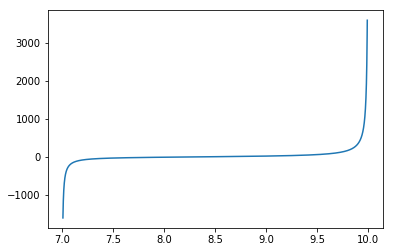

In [10]:
test_spectral = lambda x: spectral_func(a, b, gamma, x)
linspace = np.linspace(7.01, 9.99, 10000)
values = [test_spectral(x) for x in linspace]
plt.plot(linspace, values)
plt.show()

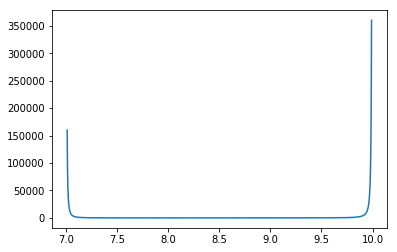

In [11]:
test_spectral_prime = lambda x: spectral_func_prime(a, b, x)
linspace = np.linspace(7.01, 9.99, 10000)
values = [test_spectral_prime(x) for x in linspace]
plt.plot(linspace, values)
plt.show()

In [12]:
def interior_sigma_coef(a, b, gamma, x, k):
    first_term = 3 * x - (gamma + a[k - 1] + a[k])
    to_sum1 = np.power(b, 2) / (a - x)
    to_sum2 = (a - a[k-1]) / (a - x)
    to_sum3 = (a - a[k]) / (a - x)
    return first_term + np.sum(to_sum1 * to_sum2 * to_sum3)

In [13]:
def interior_omega1_coef(a, b, gamma, x, k):
    a_reduced = np.delete(a, k - 1)
    b_reduced = np.delete(b, k - 1)
    to_sum1 = np.power(b_reduced, 2) / np.power(a_reduced - x, 2)
    to_sum2 = (a_reduced - a[k]) / (a_reduced - x)
    fac = np.power(a[k - 1] - x, 3) / (a[k - 1] - a[k])
    return b[k - 1] ** 2 + fac * (1 + np.sum(to_sum1 * to_sum2))

In [14]:
def interior_omega2_coef(a, b, gamma, x, k):
    a_reduced = np.delete(a, k)
    b_reduced = np.delete(b, k)
    to_sum1 = np.power(b_reduced, 2) / np.power(a_reduced - x, 2)
    to_sum2 = (a_reduced - a[k - 1]) / (a_reduced - x)
    fac = np.power(x - a[k], 3) / (a[k - 1] - a[k])
    return b[k] ** 2 + fac * (1 + np.sum(to_sum1 * to_sum2))

In [15]:
sig = interior_sigma_coef(a, b, gamma, 0.15, 1)
omega1 = interior_omega1_coef(a, b, gamma, 0.15, 1)
omega2 = interior_omega2_coef(a, b, gamma, 0.15, 1)
print(sig)
print(omega1)
print(omega2)

21.175592899164723
-1472.2674712804303
1002.3139854781166


In [16]:
def interior_alpha(a, b, gamma, x, k):
    sig = interior_sigma_coef(a, b, gamma, x, k)
    deno = (a[k - 1] - x) * (x - a[k])
    return sig / deno

In [17]:
def interior_beta(a, b, gamma, x, k):
    prime = spectral_func_prime(a, b, x)
    fac = (1 / (a[k - 1] - x)) + (1 / (a[k] - x))
    func = spectral_func(a, b, gamma, x)
    return prime - fac * func

In [18]:
alpha = interior_alpha(a, b, gamma, 0.15, 1)
beta = interior_beta(a, b, gamma, 0.15, 1)
print(alpha)
print(beta)

-0.3138403482776646
1.7239776855202118


In [19]:
def interior_increment(a, b, gamma, x, k):
    f = spectral_func(a, b, gamma, x)
    beta = interior_beta(a, b, gamma, x, k)
    alpha = interior_alpha(a, b, gamma, x, k)
    term1 = 2 * f / beta
    term2 = 2 * alpha / beta
    deno = 1 + np.sqrt(1 + term1 * term2)
    return term1 / deno

In [20]:
def interior_zero_finder(a, b, gamma, x0, k, epsilon=0.0001, maxit=1000):
    i = 0
    dist = np.inf
    x = x0
    func_track = []
    func = spectral_func(a, b, gamma, x) 
    func_track.append(func)
    dist = func ** 2
    while (dist > epsilon) and (i < maxit):
        delta = interior_increment(a, b, gamma, x, k)
        x += delta
        func = spectral_func(a, b, gamma, x) 
        dist = func ** 2
        func_track.append(func)
    return x, func_track

In [21]:
x, track = interior_zero_finder(a, b, gamma, 8.5, 1)

/home/dimitribouche/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [22]:
track

[7.32905982905983,
 15.50929045630978,
 44.05942655816947,
 -94.34357502920048,
 -15.119718803233303,
 0.05074075125944866,
 0.1013048125805529,
 0.20190964851600945,
 0.40107249266006306,
 0.7915648724379274,
 1.5438085203976701,
 2.950889446446361,
 5.479989142678182,
 9.931558724836659,
 nan]

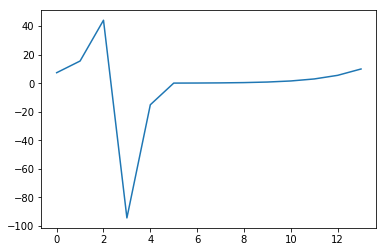

In [23]:
plt.plot(track)